In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('..')

from typing import *
from ktools.modelling.ktools_models.lgbm_model import LGBMModel
from ktools.modelling.ktools_models.xgb_model import XGBoostModel
from ktools.utils.reduce_dataframe_usage import reduce_dataframe_size
from typing import Literal
from matplotlib.pylab import RandomState
from numpy import *
from sklearn.model_selection import TimeSeriesSplit, KFold
from ktools.fitting.safe_cross_validation_executor import SafeCrossValidationExecutor
# from sklearn.metrics import
from torch.utils.data import TensorDataset
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression, SGDRegressor
from ktools.modelling.model_transform_wrappers.log_model_wrapper import LogModelWrapper
from ktools.preprocessing.basic_feature_transformers import *

In [2]:
train_csv_path = "../data/DRW_crypto_price_prediction/train.parquet"
test_csv_path = "../data/DRW_crypto_price_prediction/test.parquet"

train_df = pd.read_parquet(train_csv_path, engine='pyarrow')
test_df = pd.read_parquet(test_csv_path, engine='pyarrow')

In [11]:
train_df

,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,...,X882,X883,X884,X885,X886,X887,X888,X889,X890,label
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,15.283,8.425,176.405,44.984,221.389,0.121263,-0.417690,0.005399,0.125948,0.058359,...,1.925423,1.847943,0.005676,0.190791,0.369691,0.377630,0.210153,0.159183,0.530636,0.562539
2023-03-01 00:01:00,38.590,2.336,525.846,321.950,847.796,0.302841,-0.049576,0.356667,0.481087,0.237954,...,1.928569,1.849468,0.005227,0.184660,0.363642,0.374515,0.209573,0.158963,0.530269,0.533686
2023-03-01 00:02:00,0.442,60.250,159.227,136.369,295.596,0.167462,-0.291212,0.083138,0.206881,0.101727,...,1.928047,1.849282,0.004796,0.178719,0.357689,0.371424,0.208993,0.158744,0.529901,0.546505
2023-03-01 00:03:00,4.865,21.016,335.742,124.963,460.705,0.072944,-0.436590,-0.102483,0.017551,0.007149,...,1.928621,1.849608,0.004398,0.172967,0.351832,0.368358,0.208416,0.158524,0.529534,0.357703
2023-03-01 00:04:00,27.158,3.451,98.411,44.407,142.818,0.173820,-0.213489,0.096067,0.215709,0.107133,...,1.927084,1.848950,0.004008,0.167391,0.346066,0.365314,0.207839,0.158304,0.529167,0.362452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 23:55:00,4.163,6.805,39.037,55.351,94.388,0.020155,0.076565,0.228994,0.288856,0.151634,...,3.219345,3.340686,0.008679,0.224656,0.401595,0.393726,0.212651,0.136494,0.243172,0.396289
2024-02-29 23:56:00,2.290,4.058,110.201,67.171,177.372,0.016262,0.062527,0.214072,0.276463,0.146521,...,3.216719,3.339353,0.007928,0.217422,0.395019,0.390476,0.212063,0.136305,0.243004,0.328993
2024-02-29 23:57:00,5.237,3.640,70.499,30.753,101.252,0.045407,0.109834,0.263577,0.329266,0.174214,...,3.213444,3.337740,0.007243,0.210421,0.388549,0.387252,0.211477,0.136117,0.242836,0.189909


In [10]:
2**6

64

In [17]:
cols = train_df.columns.drop('label').tolist() + ['X890']

In [19]:
len(cols)

896

In [3]:
new_train_df = reduce_dataframe_size(train_df)
new_test_df = reduce_dataframe_size(test_df)

del train_df
del test_df

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from ktools.modelling.ktools_models.pytorch_nns.nonlinear_ff_module import NonLinearFeedForwardModule


class DeepAutoencoder(nn.Module):
    
    def __init__(self,
                 num_input_features : int,
                 levels_of_compression : int):
        
        super(DeepAutoencoder, self).__init__()

        self._num_input_features = num_input_features
        self._levels_of_compression = levels_of_compression
        
        compressions = np.cumprod([1] + [2] * levels_of_compression)

        self._encoder = nn.Sequential(*[
            NonLinearFeedForwardModule(num_input_features // compressions[i],
                                       num_input_features // compressions[i+1],
                                       num_input_features // compressions[i+1])
            for i in range(levels_of_compression - 1)
        ])

        self._decoder = nn.Sequential(*[
            NonLinearFeedForwardModule(num_input_features // compressions[i],
                                       num_input_features // compressions[i+1],
                                       num_input_features // compressions[i+1])
            for i in range(levels_of_compression - 1)[::-1]
        ])
    
    def encode(self, x):
        return self._encoder(x)

    def forward(self, x):
        x = self.encode(x)
        x = self._decoder(x)
        return x

In [5]:
from functools import reduce


settings = DataSciencePipelineSettings(train_csv_path=train_csv_path,
                                    test_csv_path=test_csv_path,
                                    target_col_name="label",
                                    train_data=new_train_df,
                                    test_data=new_test_df)

transform_list = [FillInfValues.transform,
                    FillNullValues.transform,
                    StandardScaleNumerical.transform]

new_settings = reduce(lambda acc, func: func(acc), transform_list, settings)
processed_train, processed_test = new_settings.update()

: 

In [ ]:
import torch


def custom_torch_dataloader(train_data : pd.DataFrame, batch_size : int = 64, shuffle : bool = True):
    
    num_datapoints = train_data.shape[0]
    batches = round(num_datapoints / batch_size)
    fold_obj = KFold(n_splits=batches, shuffle=shuffle, random_state=42)

    for _, batch_idcs in fold_obj.split(train_data):
        batch_data = train_data.iloc[batch_idcs]
        batch_tensor = torch.tensor(batch_data.values, dtype=torch.float32)

        
        yield TensorDataset(batch_tensor)

In [5]:
import torch
from ktools.modelling.ktools_models.pytorch_nns.pytorch_lightning_model import KtoolsBaseLightningmodel


class AutoEncoderModel(KtoolsBaseLightningmodel):

    def __init__(self, 
                 model: torch.nn.Module,
                 learning_rate: float = 0.06464861983337984, 
                 weight_decay: float = 0.0002773544957610778):
        
        super(AutoEncoderModel, self).__init__(model, learning_rate, weight_decay)

    def forward(self, x):
        return self.model(x)
    
    def get_loss(self, batch, mode = None):
        reproduce_batch = self(batch)
        loss = F.mse_loss(reproduce_batch, batch, reduction='mean')
        loss_dict = {f'{mode}_reproduction_loss' : loss}
        batch_dict = {}
        return loss, loss_dict, batch_dict
    
    def get_global_metrics(self):
        return {}

    def configure_optimizers(self):

        optimizer = torch.optim.Adam(self.parameters(), lr=self._learning_rate, weight_decay=self._weight_decay)
        scheduler_config = {
            "scheduler": torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=45,
                eta_min=6e-3
            ),
            "interval": "epoch",
            "frequency": 1,
            "strict": False,
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler_config}

In [6]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

class MyDataset(Dataset):
    def __init__(self, X):
        self.X = X

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x_row = self.X[idx].reshape(1, -1)
        return torch.as_tensor(x_row, dtype=torch.float16)


In [7]:
def init_ktools_dl(X : pd.DataFrame, target_col_name : str, training=False):

    scaler = MinMaxScaler()
    training_cols = [f for f in X.columns if f != target_col_name]

    for col_name in training_cols:
        X.loc[X[col_name] == np.inf, col_name] = -1
        X.loc[X[col_name] == -np.inf, col_name] = -2
    
    X_train = scaler.fit_transform(X[training_cols])

    ds_train = MyDataset(
        X_train
    )
    bs = 64
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=bs, pin_memory=True, shuffle=training)
    return dl_train, scaler

In [8]:
base_model = DeepAutoencoder(train_df.shape[1] - 1, 4)
model = AutoEncoderModel(base_model)

In [9]:
dl_train = init_ktools_dl(train_df, 'label')

In [10]:
checkpoint_callback = pl.callbacks.ModelCheckpoint()
trainer = pl.Trainer(
    accelerator='cpu',
    max_epochs=60,
    callbacks=[
        checkpoint_callback,
        LearningRateMonitor(logging_interval='epoch'),
        TQDMProgressBar(),
        StochasticWeightAveraging(swa_lrs=1e-5, swa_epoch_start=45, annealing_epochs=15)
    ],
    # deterministic=True
)
trainer.fit(model, dl_train)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


: 

In [4]:
class RemoveEventsFromTimePeriod(IFeatureTransformer):

    def __init__(self,
                 time_intervals_to_remove : List[Tuple[pd.Timestamp]]) -> None:
        self._time_intervals_to_remove = time_intervals_to_remove

    def transform(self, original_settings : DataSciencePipelineSettings):
        settings = deepcopy(original_settings)
        train_df, test_df = settings.update()
        for (start, end) in self._time_intervals_to_remove:
            train_df = train_df[~((train_df.index >= start) & (train_df.index <= end))]
        settings.combined_df = pd.concat([train_df, test_df], keys=['train', 'test'])
        return settings

In [5]:
list_of_major_events = [
    (pd.Timestamp("2023-03-10"), pd.Timestamp("2023-03-19")), # bank collapse
    (pd.Timestamp("2023-06-16"), pd.Timestamp("2023-06-23")),
    (pd.Timestamp("2023-08-14"), pd.Timestamp("2023-08-18")),
    (pd.Timestamp("2023-10-16"), pd.Timestamp("2023-10-25")), # blackrock etf
    (pd.Timestamp("2024-02-25"), pd.Timestamp("2024-03-13")),
]

In [31]:
def plot_time_series_data_overlay_major_dates(df : pd.DataFrame,
                                              target_col_name : str):
    df = df.sort_index()
    x = df.index
    y = df[target_col_name]
    plt.figure(figsize=(10,10))
    plt.bar(x, y, width=(x[-1] - x[0])/len(x))
    plt.show()

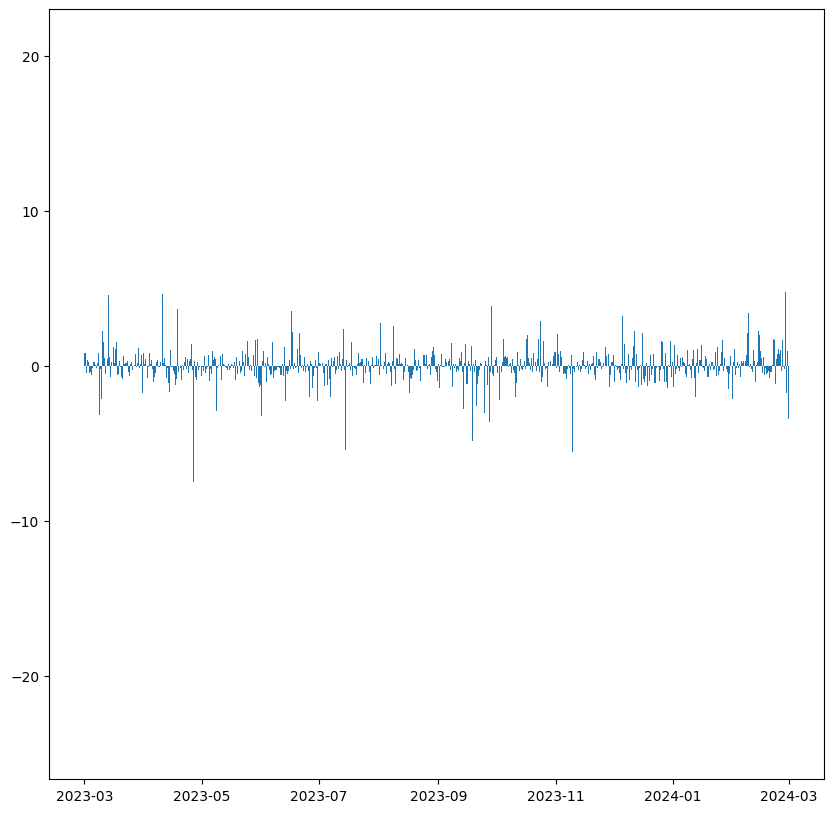

In [33]:
plot_time_series_data_overlay_major_dates(train_df, 'label')

In [6]:
mahdi_params = {
    "colsample_bylevel": 0.4778015829774066,
    "colsample_bynode": 0.362764358742407,
    "colsample_bytree": 0.7107423488010493,
    "gamma": 1.7094857725240398,
    "learning_rate": 0.02213323588455387,
    "max_depth": 20,
    "max_leaves": 12,
    "min_child_weight": 16,
    "n_estimators": 1667,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 39.352415706891264,
    "reg_lambda": 75.44843704068275,
    "subsample": 0.06566669853471274,
    "verbosity": 0
}

classifier_params = {
    'objective':'binary:logistic',
    'eval_metric':'auc',  
    "colsample_bylevel": 0.4778015829774066,
    "colsample_bynode": 0.362764358742407,
    "colsample_bytree": 0.7107423488010493,
    "gamma": 1.7094857725240398,
    "learning_rate": 0.02213323588455387,
    "max_depth": 20,
    "max_leaves": 12,
    "min_child_weight": 16,
    "n_estimators": 1667,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 39.352415706891264,
    "reg_lambda": 75.44843704068275,
    "subsample": 0.06566669853471274,
    "verbosity": 0
}

In [7]:
# binary_train = train_df.copy(deep=True)
# binary_train['label'] = np.tanh(binary_train[])

#1/(1 + np.exp(-binary_train['label'].values))
# binary_train['label'] = (binary_train['label'] > 0).astype(int)

In [13]:
from sklearn.metrics import accuracy_score

class TanhTransform(IFeatureTransformer):
    def transform(original_settings : DataSciencePipelineSettings):
        settings = deepcopy(original_settings)
        train_df, test_df = settings.update()
        train_df[settings.target_col_name] = np.tanh(train_df[settings.target_col_name])
        settings.combined_df = pd.concat([train_df, test_df], keys=['train', 'test'])
        return settings

scve = SafeCrossValidationExecutor(
    sklearn_model_instance=XGBoostModel(**mahdi_params), #SklearnWrapper(alpha=1),
    evaluation_metric=lambda x, y : pearsonr(x, y).statistic,#lambda x, y : accuracy_score(x, np.where(y > 0.5, 1, 0)),
    kfold_object=TimeSeriesSplit(5),#KFold(5, random_state=42, shuffle=True),
    train_csv_path=train_csv_path,
    test_csv_path=test_csv_path,
    target_col_name='label',
    training_features=["X863", "X856", "X344", "X598", "X862", "X385", "X852", "X603", "X860", "X674",
    "X415", "X345", "X137", "X855", "X174", "X302", "X178", "X532", "X168", "X612",
    "bid_qty", "ask_qty", "buy_qty", "sell_qty", "volume"],
    pipeline_transforms=[
        # ReduceMemoryUsage.transform,
        # TanhTransform.transform,
        RemoveEventsFromTimePeriod(list_of_major_events).transform,
        FillInfValues.transform,
        # lambda x : RemoveOutliers.transform(x, lq=0.2, uq=0.8),
        FillNullValues.transform,
        StandardScaleNumerical.transform
                        ]
)
(score_tuple,
 sign_oof_predictions,
 model_list,
 sign_test_predictions) = scve.run(train_data=train_df, test_data=test_df, weights=[0.8] * int(train_df.shape[0]/2) + [1.3] * (train_df.shape[0] - int(train_df.shape[0]/2)))

/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/sklearn/model_selection/_split.py:1213: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


0it [00:00, ?it/s]INFO:cross_validation_log:The CV results of the current fold is 0.08138730376958847
1it [00:02,  2.13s/it]INFO:cross_validation_log:The CV results of the current fold is 0.03161057457327843
2it [00:05,  2.58s/it]INFO:cross_validation_log:The CV results of the current fold is 0.09128579497337341
3it [00:09,  3.35s/it]INFO:cross_validation_log:The CV results of the current fold is 0.1347571164369583
4it [00:14,  3.95s/it]INFO:cross_validation_log:The CV results of the current fold is 0.019442427903413773
5it [00:19,  3.90s/it]

####################################################################################################
OOF prediction score :  0.07104451111536203
Mean 5-cv results : 0.07169664651155472 +- 0.04193247854709625
####################################################################################################


In [10]:
train_df['label'] = np.abs(train_df['label'])

In [11]:
from sklearn.metrics import root_mean_squared_error


scve = SafeCrossValidationExecutor(
    sklearn_model_instance=XGBoostModel(**mahdi_params), #SklearnWrapper(alpha=1),
    evaluation_metric=root_mean_squared_error,
    kfold_object=TimeSeriesSplit(5),#KFold(5, random_state=42, shuffle=True),
    train_csv_path=train_csv_path,
    test_csv_path=test_csv_path,
    target_col_name='label',
    training_features=["X863", "X856", "X344", "X598", "X862", "X385", "X852", "X603", "X860", "X674",
    "X415", "X345", "X137", "X855", "X174", "X302", "X178", "X532", "X168", "X612",
    "bid_qty", "ask_qty", "buy_qty", "sell_qty", "volume"],
    pipeline_transforms=[
        # ReduceMemoryUsage.transform,
        # RemoveEventsFromTimePeriod(list_of_major_events).transform,
        FillInfValues.transform,
        # lambda x : RemoveOutliers.transform(x, lq=0.2, uq=0.8),
        FillNullValues.transform,
        StandardScaleNumerical.transform
                        ]
)

(score_tuple,
 mag_oof_predictions,
 model_list,
 mag_test_predictions) = scve.run(train_data=train_df, test_data=test_df)

/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/sklearn/model_selection/_split.py:1213: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(
0it [00:00, ?it/s]

INFO:cross_validation_log:The CV results of the current fold is 0.7370205521583557
1it [00:01,  2.00s/it]INFO:cross_validation_log:The CV results of the current fold is 0.7975037097930908
2it [00:04,  2.49s/it]INFO:cross_validation_log:The CV results of the current fold is 0.7684149742126465
3it [00:08,  2.99s/it]INFO:cross_validation_log:The CV results of the current fold is 0.6767498850822449
4it [00:12,  3.36s/it]INFO:cross_validation_log:The CV results of the current fold is 0.7725720405578613
5it [00:17,  3.40s/it]

####################################################################################################
OOF prediction score :  0.8035643742475335
Mean 5-cv results : 0.7504522204399109 +- 0.04156497120857239
####################################################################################################


In [12]:
pearsonr(mag_oof_predictions * (sign_oof_predictions - 0.5), train_df['label']).statistic

0.049725249693240915

In [10]:
class SklearnWrapper(SGDRegressor):

    def __init__(
        self,
        loss="squared_error",
        *,
        penalty="l2",
        alpha=0.0001,
        l1_ratio=0.15,
        fit_intercept=True,
        max_iter=1000,
        tol=1e-3,
        shuffle=True,
        verbose=0,
        epsilon=0.1,
        random_state=129,
        learning_rate="invscaling",
        eta0=0.01,
        power_t=0.25,
        early_stopping=False,
        validation_fraction=0.1,
        n_iter_no_change=5,
        warm_start=False,
        average=False,
    ):
        super().__init__(
            loss=loss,
            penalty=penalty,
            alpha=alpha,
            l1_ratio=l1_ratio,
            fit_intercept=fit_intercept,
            max_iter=max_iter,
            tol=tol,
            shuffle=shuffle,
            verbose=verbose,
            epsilon=epsilon,
            random_state=random_state,
            learning_rate=learning_rate,
            eta0=eta0,
            power_t=power_t,
            early_stopping=early_stopping,
            validation_fraction=validation_fraction,
            n_iter_no_change=n_iter_no_change,
            warm_start=warm_start,
            average=average,
        )

    def fit(self, X, y, **kwargs):
        return super().fit(X, y)
    

scve = SafeCrossValidationExecutor(
    sklearn_model_instance=XGBoostModel(**mahdi_params), #SklearnWrapper(alpha=1),
    evaluation_metric=lambda x, y : pearsonr(x, y).statistic,
    kfold_object=TimeSeriesSplit(5),
    train_csv_path=train_csv_path,
    test_csv_path=test_csv_path,
    target_col_name='label',
    training_features=["X863", "X856", "X344", "X598", "X862", "X385", "X852", "X603", "X860", "X674",
    "X415", "X345", "X137", "X855", "X174", "X302", "X178", "X532", "X168", "X612",
    "bid_qty", "ask_qty", "buy_qty", "sell_qty", "volume"],
    pipeline_transforms=[
        # ReduceMemoryUsage.transform,
        RemoveEventsFromTimePeriod(list_of_major_events).transform,
        FillInfValues.transform,
        # lambda x : RemoveOutliers.transform(x, lq=0.2, uq=0.8),
        FillNullValues.transform,
        StandardScaleNumerical.transform
                        ]
)

In [11]:
(score_tuple,
 oof_predictions,
 model_list,
 test_predictions) = scve.run(train_data=train_df, test_data=test_df)

/Users/yuwei-1/anaconda3/envs/ktools/lib/python3.12/site-packages/sklearn/model_selection/_split.py:1213: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(
0it [00:00, ?it/s]INFO:cross_validation_log:The CV results of the current fold is 0.10367283225059509
1it [00:02,  2.91s/it]INFO:cross_validation_log:The CV results of the current fold is 0.0839976966381073
2it [00:07,  3.80s/it]INFO:cross_validation_log:The CV results of the current fold is 0.045926980674266815
3it [00:12,  4.08s/it]

####################################################################################################
OOF prediction score :  0.06885551907582667
Mean 3-cv results : 0.0778658390045166 +- 0.02397006005048752
####################################################################################################


In [10]:
sample_sub = pd.read_csv("/Users/yuwei-1/Documents/projects/Kaggle-tools/data/DRW_crypto_price_prediction/sample_submission.csv", index_col=0)
sample_sub['prediction'] = sign_test_predictions#mag_test_predictions * (sign_test_predictions - 0.5)#test_predictions
sample_sub.to_csv("/Users/yuwei-1/Documents/projects/Kaggle-tools/submissions/drw/submission_25.csv")

In [11]:
sample_sub

,prediction
ID,
1,-0.002162
2,-0.020968
3,0.035647
4,-0.003229
5,0.058872
...,...
538146,-0.031419
538147,-0.027702
538148,0.049828
